# Задачи


In [1]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

# Set pandas default float format

pd.options.display.float_format = '{:,.2f}'.format


## Банкови заеми

Банка е в процеса на определяне на кредитната си политика за пет
различни сектора с характеристики дадени в следната таблица:

| Вид кредит      | Лихва | Дял на несъбираеми кредити |
|-----------------|------:|---------------------------:|
| Потребителски   |  0.15 |                       0.10 |
| Автомобили      |  0.13 |                       0.07 |
| Недвижими имоти |  0.12 |                       0.03 |
| Земеделие       | 0.125 |                       0.05 |
| Търговия        |  0.10 |                       0.02 |

Банката разполага с общо 12 милиона лева и при определяне на политиката
трябва да се съобрази със следните регулации:

1. Поне 40% от заемите трябва да са за земеделие или търговия.
2. Заеми за недвижими имоти трябва да са поне половината от общата сума на потребителски кредити, кредити свързани с автомобили и недвижими имоти.
3. По силата на регулаторни изисквания дялът на несъбираемите кредити не трябва да надвишава 4% от всички кредити. Несъбираемите кредити не носят лихви.

Какъв е оптималният (най-висока печалба) план за банката?

:::{.callout-note collapse="true"}
## Математически модел

$$
\begin{align*}
x_{п} & : \text{потребителски кредити в млн. лв.} \\
x_{а} & : \text{кредити за автомобили в млн. лв.} \\
x_{н} & : \text{жилищни кредити (недвижими имоти) в млн. лв.} \\
x_{з} & : \text{земеделски кредити в млн. лв.} \\
x_{т} & : \text{търговски кредити в млн. лв.}
\end{align*}
$$

Отчитайки, че несъбираемите кредити не носят лихви, общата лихва възлиза на

$$
\begin{align*}
x_{\text{лихви}} = & 0.15(1 - 0.1)x_{п} + \\
               & 0.13(1 - 0.07)x_{а} + \\
               & 0.12(1 - 0.03)x_{н} + \\
               & 0.125(1 - 0.05)x_{з} + \\
               & 0.10(1 - 0.02)x_{т}
\end{align*}
$$

Несъбираемите кредити възлизат на 

$$
x_{\text{несъбираеми}} = 0.10x_{п} + 0.07x_{а} + 0.03x_{н} + 0.05x_{з} + 0.02x_{т}
$$

Целевата функция (печалба) е разликата от лихвите и несъбираемите кредити

$$
\max \text{Печалба}(x_{п}, x_{а}, x_{н}, x_{з}, x_{т}) = x_{\text{лихви}} - x_{\text{несъбираеми}}
$$

Ограниченията в задачата са 5:

1. Общият обем на отпуснатите кредити да не надвишава 12 млн. лв.:

$$
x_\text{общо} = x_{п} + x_{а} + x_{н} + x_{з} + x_{т} \leq 12
$$

2. Поне 40% от кредитите да са насочени към търговския или земеделския сектор: 

$$
x_{т} + x_{з} \geq 0.4x_\text{общо}
$$

3. Кредитите за недвижими имоти да са поне половината от общата сума на потребителски кредити, кредити свързани с автомобили и недвижими имоти:

$$
x_{н} \geq \frac{1}{2}(x_{п} + x_{а} + x_{н})
$$

4. Дялът на несъбираемите кредити не трябва да надвишава 4% от всички кредити:

$$
x_{\text{несъбираеми}} \leq 0.04x_\text{общо}
$$

5. Неотрицателност на отпуснатите кредити:

$$
x_{п}, x_{а}, x_{н}, x_{з}, x_{т} \geq 0
$$

:::

Имплементация на модела в Excel може да видите [тук](https://github.com/febse/data/raw/refs/heads/main/opt/Bank-loans.xlsx).

In [2]:
# Create a new model
m = gp.Model("Bank Loans")
m.params.LogToConsole = 0

# Create variables
x_cons = m.addVar(name="Consumer")
x_auto = m.addVar(name="Automobile")
x_home = m.addVar(name="Residential")
x_agr = m.addVar(name="Agricultural")
x_comm = m.addVar(name="Commercial")

# Set objective

interest = 0.15 * (1 - 0.1) * x_cons + 0.13 * (1 - 0.07) * x_auto + 0.12 * (1 - 0.03) * x_home + 0.125 * (
            1 - 0.05) * x_agr + 0.1 * (1 - 0.02) * x_comm
defaults = 0.1 * x_cons + 0.07 * x_auto + 0.03 * x_home + 0.05 * x_agr + 0.02 * x_comm

m.setObjective(interest - defaults, GRB.MAXIMIZE)

# Constraints

x_all = x_cons + x_auto + x_home + x_agr + x_comm

m.addConstr(x_all <= 12, "Budget")
m.addConstr(x_agr + x_comm >= 0.4 * x_all, "Agriculture and Commercial Loans >= 40% of all loans")
m.addConstr(x_home >= 0.5 * (x_cons + x_auto + x_home), "Residential loans >= 50% of consumer, automobile, and residential loans")
m.addConstr(defaults <= 0.04 * x_all, "Defaults <= 4% of Total Loans")

m.optimize()

vars_df = pd.DataFrame(
    data=[(var.varName, var.x, var.RC) for var in m.getVars()],
    columns=["Variable", "Value", "RC"]
    )
constr_df = pd.DataFrame(
    data=[(constr.constrName, constr.slack, constr.pi) for constr in m.getConstrs()],
    columns=["Constraint", "Slack", "Dual"]
)

m.write("bank_loans.lp")

with open("bank_loans.lp", "r") as f:
    print(f.read())

# Print objective value

print(f"Optimal Value: {m.objVal}")


Restricted license - for non-production use only - expires 2026-11-23


Set parameter LogToConsole to value 0


\ Model Bank Loans
\ LP format - for model browsing. Use MPS format to capture full model detail.
Maximize
  0.035 Consumer + 0.0509 Automobile + 0.0864 Residential
   + 0.06875 Agricultural + 0.078 Commercial
Subject To
 Budget: Consumer + Automobile + Residential + Agricultural + Commercial
   <= 12
 Agriculture_and_Commercial_Loans_>=_40%_of_all_loans: - 0.4 Consumer
   - 0.4 Automobile - 0.4 Residential + 0.6 Agricultural + 0.6 Commercial
   >= 0
 Residential_loans_>=_50%_of_consumer,_automobile,_and_residential_loans:
   - 0.5 Consumer - 0.5 Automobile + 0.5 Residential >= 0
 Defaults_<=_4%_of_Total_Loans: 0.06 Consumer + 0.03 Automobile
   - 0.01 Residential + 0.01 Agricultural - 0.02 Commercial <= 0
Bounds
End

Optimal Value: 0.9964799999999999


In [3]:
#| label: tbl-bank-loans-variables
#| tbl-cap: "Стойности на променливите в оптимума за банковите заеми"

vars_df

,Variable,Value,RC
0,Consumer,0.00,-0.05
1,Automobile,0.00,-0.04
2,Residential,7.20,0.00
3,Agricultural,0.00,-0.01
4,Commercial,4.80,0.00


In [4]:
#| label: tbl-bank-loans-constraints
#| tbl-cap: "Ограничения за банковите заеми в оптимума"

constr_df

,Constraint,Slack,Dual
0,Budget,0.00,0.08
1,Agriculture and Commercial Loans >= 40% of all...,0.00,-0.01
2,"Residential loans >= 50% of consumer, automobi...",-3.60,0.00
3,Defaults <= 4% of Total Loans,0.17,0.00


## Диета

Първият проблем, решен с използването на симплекс алгоритъма за решаване на линейни оптимизационни задачи, е била задачата за оптимално съставяне на диета, която да отговаря на определени хранителни изисквания и да бъде с минимални разходи. Нека да разгледаме следната задача:

| Food          | Порция | Кило калории | Протеин (гр.) | Калций (mg) | Цена на порция |
|---------------|--------|--------------|---------------|-------------|----------------|
| Овесена каша  | 28 г   | 110          | 4             | 2           | 3 лв.          |
| Пилешко месо  | 100 г  | 205          | 32            | 12          | 24 лв.         |
| Яйца          | две    | 160          | 13            | 54          | 13 лв.         |
| Мляко         | 237 мл | 160          | 8             | 285         | 9 лв.          |
| Черешов пай   | 170 г  | 420          | 4             | 22          | 20 лв.         |
| Свинско с боб | 260 г  | 260          | 14            | 80          | 19 лв.         |

От характеристиките на различните цени искаме да намерим такава комбинация, че калорийното съдържание на менюто да е поне 2 000 кило калории, да съдържа поне 55 г протеини и 800 мг калций.

Формулирайте линейна оптимизационна задача, която да намери най-евтиното меню.

Имплементация на модела в Excel може да видите [тук](https://github.com/febse/data/raw/refs/heads/main/opt/diet.xlsx).

In [5]:
m = gp.Model("Diet")
m.Params.LogToConsole = 0

# Create variables

v_names = ["Oatmeal", "Chicken", "Eggs", "Whole Milk", "Cherry pie", "Pork with beans"]

x = m.addVars(len(v_names), name=v_names, lb=0)

c = [3, 24, 13, 9, 20, 19]

# Set objective

m.setObjective(gp.quicksum(c[i] * x[i] for i in range(len(v_names))), GRB.MINIMIZE)

# Constraints

# Calories

m.addConstr(110 * x[0] + 205 * x[1] + 160 * x[2] + 160 * x[3] + 420 * x[4] + 260 * x[5] >= 2000, "Calories")

# Protein

m.addConstr(4 * x[0] + 32 * x[1] + 13 * x[2] + 8 * x[3] + 4 * x[4] + 14 * x[5] >= 55, "Protein")

# Calcium

m.addConstr(2 * x[0] + 12 * x[1] + 54 * x[2] + 285 * x[3] + 22 * x[4] + 80 * x[5] >= 800, "Calcium")

m.optimize()

vars_df = pd.DataFrame(
    data=[(var.varName, var.x, var.RC) for var in m.getVars()],
    columns=["Variable", "Value", "RC"]
    )
constr_df = pd.DataFrame(
    data=[(constr.constrName, constr.slack, constr.pi) for constr in m.getConstrs()],
    columns=["Constraint", "Slack", "Dual"]
)

m.write("diet.lp")

with open("diet.lp", "r") as f:
    print(f.read())


Set parameter LogToConsole to value 0


\ Model Diet
\ LP format - for model browsing. Use MPS format to capture full model detail.
Minimize
  3 Oatmeal + 24 Chicken + 13 Eggs + 9 Whole_Milk + 20 Cherry_pie
   + 19 Pork_with_beans
Subject To
 Calories: 110 Oatmeal + 205 Chicken + 160 Eggs + 160 Whole_Milk
   + 420 Cherry_pie + 260 Pork_with_beans >= 2000
 Protein: 4 Oatmeal + 32 Chicken + 13 Eggs + 8 Whole_Milk + 4 Cherry_pie
   + 14 Pork_with_beans >= 55
 Calcium: 2 Oatmeal + 12 Chicken + 54 Eggs + 285 Whole_Milk + 22 Cherry_pie
   + 80 Pork_with_beans >= 800
Bounds
End



In [6]:
vars_df

,Variable,Value,RC
0,Oatmeal,14.24,0.00
1,Chicken,0.00,18.27
2,Eggs,0.00,7.80
3,Whole Milk,2.71,0.00
4,Cherry pie,0.00,8.31
5,Pork with beans,0.00,10.67


Нека разгледаме и модификация на задачата, която ограничава колко най-много порции от всеки продукт могат да се предложат на ден.


| Food          | Максимум порции на ден |
|---------------|------------------------|
| Овесена каша  | 4           |
| Пилешко месо  |  3           |
| Яйца          |  2           |
| Мляко         |  8           |
| Черешов пай   |  2           |
| Свинско с боб |  2           |


In [7]:
m = gp.Model("Diet")
m.Params.LogToConsole = 0

# Create variables

v_names = ["Oatmeal", "Chicken", "Eggs", "Whole Milk", "Cherry pie", "Pork with beans"]

x = m.addVars(len(v_names), name=v_names, lb=0, ub = [4, 3, 2, 8, 2, 2])

c = [3, 24, 13, 9, 20, 19]

# Set objective

m.setObjective(gp.quicksum(c[i] * x[i] for i in range(len(v_names))), sense=GRB.MINIMIZE)

# Constraints

# Calories

m.addConstr(110 * x[0] + 205 * x[1] + 160 * x[2] + 160 * x[3] + 420 * x[4] + 260 * x[5] >= 2000, "Calories")

# Protein

m.addConstr(4 * x[0] + 32 * x[1] + 13 * x[2] + 8 * x[3] + 4 * x[4] + 14 * x[5] >= 55, "Protein")

# Calcium

m.addConstr(2 * x[0] + 12 * x[1] + 54 * x[2] + 285 * x[3] + 22 * x[4] + 80 * x[5] >= 800, "Calcium")

m.optimize()

vars_df = pd.DataFrame(
    data=[(var.varName, var.x, var.RC) for var in m.getVars()],
    columns=["Variable", "Value", "RC"]
    )
constr_df = pd.DataFrame(
    data=[(constr.constrName, constr.slack, constr.pi) for constr in m.getConstrs()],
    columns=["Constraint", "Slack", "Dual"]
)

m.write("diet.lp")

with open("diet.lp", "r") as f:
    print(f.read())


Set parameter LogToConsole to value 0


\ Model Diet
\ LP format - for model browsing. Use MPS format to capture full model detail.
Minimize
  3 Oatmeal + 24 Chicken + 13 Eggs + 9 Whole_Milk + 20 Cherry_pie
   + 19 Pork_with_beans
Subject To
 Calories: 110 Oatmeal + 205 Chicken + 160 Eggs + 160 Whole_Milk
   + 420 Cherry_pie + 260 Pork_with_beans >= 2000
 Protein: 4 Oatmeal + 32 Chicken + 13 Eggs + 8 Whole_Milk + 4 Cherry_pie
   + 14 Pork_with_beans >= 55
 Calcium: 2 Oatmeal + 12 Chicken + 54 Eggs + 285 Whole_Milk + 22 Cherry_pie
   + 80 Pork_with_beans >= 800
Bounds
 Oatmeal <= 4
 Chicken <= 3
 Eggs <= 2
 Whole_Milk <= 8
 Cherry_pie <= 2
 Pork_with_beans <= 2
End



In [8]:
vars_df

,Variable,Value,RC
0,Oatmeal,4.00,-3.19
1,Chicken,0.00,12.47
2,Eggs,0.00,4.00
3,Whole Milk,4.50,0.00
4,Cherry pie,2.00,-3.62
5,Pork with beans,0.00,4.38


## Планиране на градско строителство

Да приемем, че София е изправена пред дефицит в местния бюджет и общинският съвет обмисля как да увеличи приходите от данък сгради чрез преустройства на общински имоти. Проектът се състои от две части -- разчистване на занемарени и повредени постройки и построяване на нови жилища.

1. В момента на планиране общината притежава 300 занемарени постройки, които могат да бъдат съборени. Всяка от тях освобождава 1000 кв. метра и събарянето й струва 3 000 лв. на постройка. 15 процента от освободеното пространство е предвидено за улици, тротоари и свободни  пространства.
2. На освободените парцели общината може да построи четири вида нови жилищни сгради: еднофамилни (300 кв. метра), двуфамилни (500 кв. метра), три-фамилни (700 кв. метра) и четири-фамилни къщи (900 кв. метра). Очакваните данъчни постъпления са съответно 1 000 лв., 1 700 лв., 2 400 лв. и 2 800 лв. на година.
3. Поне 20 процента от новите постройки трябва да са еднофамилни къщи, двуфамилните домове трябва да съставляват поне 20 процента, а три и четири-фамилните домове трябва (заедно) да са поне една четвърт от всички нови постройки.
4. Строителните разходи за новите домове са съответно 50 000 лв., 70 000 лв., 130 000 лв. и 160 000 лв.
5. Общината предвижда на финансира проекта чрез банков заем, който не може да надвишава 15 милиона лева.

Колко от всеки вид къщи трябва да планира да построи общината, така че да постигне възможно най-високи данъчни постъпления?

:::{.callout-note collapse="true"}
## Математически модел

Променливи

$$
\begin{align*}
x_{1} & : \text{брой еднофамилни къщи} \\
x_{2} & : \text{брой двуфамилни къщи} \\
x_{3} & : \text{брой трифамилни къщи} \\
x_{4} & : \text{брой четирифамилни къщи} \\
x_{d} & : \text{брой съборени постройки}
\end{align*}
$$

Целева функция (в хиляди лева)

$$
\max x_{1} + 1.7x_{2} + 2.4x_{3} + 2.8x_{4}
$$

Ограничения

1. Площ

$$
300x_{1} + 500x_{2} + 700x_{3} + 900x_{4} \leq (1 - 0.15) \cdot 1000 \cdot x_{d}
$$

2. Брой съборени постройки

$$
x_{d} \leq 300
$$

3. Съотношения между видовете нови къщи
$$
x_{all} = x_{1} + x_{2} + x_{3} + x_{4}
$$

$$
\begin{align*}
x_{1} \geq 0.2 x_{all} \\
x_{2} \geq 0.2 x_{all} \\
x_{3} + x_{4} \geq 0.25 x_{all}
\end{align*}
$$

4. Финансови ограничения (в хиляди лева)
$$
50x_{1} + 70x_{2} + 130x_{3} + 160x_{4} + 3x_{d} \leq 15000
$$

:::


In [9]:
#| fold-code: true

m = gp.Model("Urban Planning")
m.params.LogToConsole = 0

# Create variables
x1 = m.addVar(name="Single")
x2 = m.addVar(name="Double")
x3 = m.addVar(name="Triple")
x4 = m.addVar(name="Quadruple")
xd = m.addVar(name="Demolished")

# Set objective
m.setObjective(x1 + 1.7 * x2 + 2.4 * x3 + 2.8 * x4, GRB.MAXIMIZE)

# Add constraints
m.addConstr(300 * x1 + 500 * x2 + 700 * x3 + 900 * x4 <= (1000 - 0.15) * xd, "Area")
m.addConstr(xd <= 300, "Demolitions")
m.addConstr(-0.8 * x1 + 0.2 * x2 + 0.2 * x3 + 0.2 * x4 <= 0, "Single")
m.addConstr(0.1 * x1 - 0.9 * x2 + 0.1 * x3 + 0.1 * x4 <= 0, "Double")
m.addConstr(0.25 * x1 + 0.25 * x2 - 0.75 * x3 - 0.75 * x4 <= 0, "Triple/Quadruple")
m.addConstr(50 * x1 + 70 * x2 + 130 * x3 + 160 * x4 + 3 * xd <= 15000, "Budget")

# Optimize model
m.optimize()

# Print results
print('Model Status:', m.status)
print('Objective:', m.objVal)

var_df = pd.DataFrame(columns=['Variable', 'Value', 'RC'], data=[(v.VarName, v.X, v.RC) for v in m.getVars()])
constr_df = pd.DataFrame(columns=['Constraint', 'Slack', 'Shadow Price', 'Lower', 'Upper'],
                         data=[(c.ConstrName, c.Slack, c.Pi, c.SARHSLow, c.SARHSUp) for c in m.getConstrs()])

m.write("urban_planning.lp")

with open("urban_planning.lp", "r") as f:
    print(f.read())

Set parameter LogToConsole to value 0


Model Status: 2
Objective: 315.3389993801341
\ Model Urban Planning
\ LP format - for model browsing. Use MPS format to capture full model detail.
Maximize
  Single + 1.7 Double + 2.4 Triple + 2.8 Quadruple
Subject To
 Area: 300 Single + 500 Double + 700 Triple + 900 Quadruple
   - 999.85 Demolished <= 0
 Demolitions: Demolished <= 300
 Single: - 0.8 Single + 0.2 Double + 0.2 Triple + 0.2 Quadruple <= 0
 Double: 0.1 Single - 0.9 Double + 0.1 Triple + 0.1 Quadruple <= 0
 Triple/Quadruple: 0.25 Single + 0.25 Double - 0.75 Triple - 0.75 Quadruple
   <= 0
 Budget: 50 Single + 70 Double + 130 Triple + 160 Quadruple + 3 Demolished
   <= 15000
Bounds
End



In [10]:
#| label: tbl-urban-planning-variables
#| tbl-cap: "Стойности на променливите в оптимума за градското строителство"

var_df

,Variable,Value,RC
0,Single,36.35,0.00
1,Double,99.96,0.00
2,Triple,45.44,0.00
3,Quadruple,0.00,-0.24
4,Demolished,92.71,0.00


In [11]:
#| label: tbl-urban-planning-constraints
#| tbl-cap: "Ограничения за градското строителство в оптимума за градското строителство"

constr_df

,Constraint,Slack,Shadow Price,Lower,Upper
0,Area,0.00,0.00,"-211,177.22","94,444.44"
1,Demolitions,207.29,0.00,92.71,inf
2,Single,0.00,0.27,-92.14,34.62
3,Double,81.79,0.00,-81.79,inf
4,Triple/Quadruple,0.00,0.57,-61.48,55.65
5,Budget,0.00,0.02,0.00,"48,539.91"




## Производство и неустойки

Малък шивашки цех се опитва да определи производствения си план за следващия сезон. Цехът произвежда
четири продукта: якета, шапки, ръкавици и панталони, които се произвеждат в четири отделения: рязане, уплътняване, шиене и пакетиране.


| Отделения/продукти | Якета | Шапки | Ръкавици | Панталони | Капацитет (часове) |
|--------------------|------:|------:|---------:|----------:|-------------------:|
| Рязане             |   0.3 |   0.3 |     0.25 |      0.15 |               1000 |
| Уплътняване        |  0.25 |  0.35 |      0.3 |      0.10 |               1000 |
| Шиене              |  0.45 |   0.5 |      0.4 |      0.22 |               1000 |
| Пакетиране         |  0.12 |  0.15 |      0.1 |      0.05 |               1000 |


Цехът вече има получени поръчки за четирите продукта. Договорите за производство включват неустойка за всяка недоставена единица:

| Отделения/продукти   | Якета | Шапки | Ръкавици | Панталони |
|----------------------|------:|------:|---------:|----------:|
| Поръчки (брой)       |   800 |   750 |      600 |       600 |
| Печалба (лв./брой)   |    30 |    40 |       20 |        10 |
| Неустойка (лв./брой) |    15 |    20 |       10 |         8 |


Намерете оптималния производствен план за този цех.

<!-- :::{.callout-note collapse="true"}
## Математически модел

$$
\begin{align}
x_{jackets} & : \text{брой якета} \\
x_{hats} & : \text{брой шапки} \\
x_{gloves} & : \text{брой ръкавици} \\
x_{pants} & : \text{брой панталони}
\end{align}
$$

Общата печалба от производството е равна на печалбата от продажбата на 
минус разходите за неустойки:

Печалбата от продажба е равна на количествата произведени продукти умножени по цената на единица:

$$
\text{profit (sale)} = 30x_{jackets} + 40x_{hats} + 20x_{gloves} + 10x_{pants}
$$

Разходите за неустойки се определят от разликата между поръчките и произведените продукти:

$$
\begin{align}
x_{jackets} + s_{jackets} = 800 \\
x_{hats} + s_{hats} = 750 \\
x_{gloves} + s_{gloves} = 600 \\
x_{pants} + s_{pants} = 600
\end{align}
$$

където $s_{jackets}$, $s_{hats}$, $s_{gloves}$ и $s_{pants}$ са разликите между произведени и поръчани продукти. Общата неустойка е равна на сбора от неустойките за всеки продукт:

$$
\text{penalty} = 15s_{jackets} + 20s_{hats} + 10s_{gloves} + 8s_{pants}
$$

В задачата има още и ограничения за капацитета на отделенията:

$$
0.3 x_{jackets} + 0.3 x_{hats} + 0.25 x_{gloves} + 0.15 x_{pants} \leq 1000 \\
0.25 x_{jackets} + 0.35 x_{hats} + 0.3 x_{gloves} + 0.10 x_{pants} \leq 1000 \\
0.45 x_{jackets} + 0.5 x_{hats} + 0.4 x_{gloves} + 0.22 x_{pants} \leq 1000 \\
0.12 x_{jackets} + 0.15 x_{hats} + 0.1 x_{gloves} + 0.05 x_{pants} \leq 1000
$$

Накрая има и ограничения за неотрицателност на променливите:

$$
\begin{align*}
x_{jackets}, x_{hats}, x_{gloves}, x_{pants} \geq 0 \\
s_{jackets}, s_{hats}, s_{gloves}, s_{pants} \geq 0
\end{align*}
$$

::: -->



In [12]:
# Create a new model
m = gp.Model("Production and Penalty")
m.Params.LogToConsole = 0

# Create variables
jackets = m.addVar(name="Jackets")
hats = m.addVar(name="Hats")
gloves = m.addVar(name="Gloves")
pants = m.addVar(name="Pants")

# Set objective

profit_sales = 30 * jackets + 40 * hats + 20 * gloves + 10 * pants

# The deficit of jackets, hats, gloves and pants

jackets_deficit = 800 - jackets
hats_deficit = 750 - hats
gloves_deficit = 600 - gloves
pants_deficit = 600 - pants

penalty = 15 * jackets_deficit + 20 * hats_deficit + 10 * gloves_deficit + 8 * pants_deficit

m.setObjective(profit_sales - penalty, GRB.MAXIMIZE)

# Constraints

# The production of jackets, hats, gloves and pants

m.addConstr(0.3 * jackets + 0.3 * hats + 0.25 * gloves + 0.15 * pants <= 1000, "Cutting")
m.addConstr(0.25 * jackets + 0.35 * hats + 0.3 * gloves + 0.1 * pants <= 1000, "Sewing")
m.addConstr(0.45 * jackets + 0.5 * hats + 0.4 * gloves + 0.22 * pants <= 1000, "Sealing")
m.addConstr(0.12 * jackets + 0.15 * hats + 0.1 * gloves + 0.05 * pants <= 1000, "Packaging")

m.optimize()

var_df = pd.DataFrame(columns=['Variable', 'Value', 'RC'], data=[(v.VarName, v.X, v.RC) for v in m.getVars()])
constr_df = pd.DataFrame(columns=['Constraint', 'Slack', 'Shadow Price', 'Lower', 'Upper'],
                         data=[(c.ConstrName, c.Slack, c.Pi, c.SARHSLow, c.SARHSUp) for c in m.getConstrs()])



Set parameter LogToConsole to value 0


In [13]:
#| label: tbl-production-penalty-variables
#| tbl-cap: "Стойности на променливите в оптимума за производство и неустойки"

var_df

,Variable,Value,RC
0,Jackets,0.00,-9.00
1,Hats,"2,000.00",0.00
2,Gloves,0.00,-18.00
3,Pants,0.00,-8.40


In [14]:
#| label: tbl-production-penalty-constraints
#| tbl-cap: "Ограничения за производство и неустойки в оптимума за производство и неустойки"

constr_df

,Constraint,Slack,Shadow Price,Lower,Upper
0,Cutting,400.00,0.00,600.00,inf
1,Sewing,300.00,0.00,700.00,inf
2,Sealing,0.00,120.00,0.00,"1,428.57"
3,Packaging,700.00,0.00,300.00,inf


## Производство и склад

Компания за производство на дограма има договор за доставка на дървени дограми за следващите 6 месеца. За същия период компанията очаква разходите за производство (труд и материали) да варират. Компанията може да се възползва от по-ниски производствени разходи в даден период и да произведе повече дограми от необходимото, като разходите за складиране на продуктите са 8 лв. на месец на брой. В момента на планиране фирмата няма готови дограми на склад. В края на периода за планиране компанията изисква да няма дограми на склад.

|                                   | Януари | Февруари | Март | Април | Май | Юни |
|-----------------------------------|-------:|---------:|-----:|------:|-----|-----|
| Поръчки (брой)                    |    100 |      250 |  190 |   140 | 220 | 110 |
| Производствени разходи (лв./брой) |     50 |       45 |   55 |    48 | 52  | 50  |


Формулирайте оптимизационна задача, която да намери оптималния производствен план.

:::{.callout-note collapse="true"}
## Математически модел

$$
\begin{align*}
x_{jan} & : \text{брой дограми произведени през януари} \\
x_{feb} & : \text{брой дограми произведени през февруари} \\
x_{mar} & : \text{брой дограми произведени през март} \\
x_{apr} & : \text{брой дограми произведени през април} \\
x_{may} & : \text{брой дограми произведени през май} \\
x_{jun} & : \text{брой дограми произведени през юни} \\
\end{align*}
$$

$$
\begin{align*}
y_{jan} & : \text{брой дограми на склад в края на януари} \\
y_{feb} & : \text{брой дограми на склад в края на февруари} \\
y_{mar} & : \text{брой дограми на склад в края на март} \\
y_{apr} & : \text{брой дограми на склад в края на април} \\
y_{may} & : \text{брой дограми на склад в края на май} \\
y_{jun} & : \text{брой дограми на склад в края на юни}
\end{align*}
$$

Общите производствени разходи са равни на сбора от произведените дограми умножен по цената на единица:

$$
\text{production cost} = 50x_{jan} + 45x_{feb} + 55x_{mar} + 48x_{apr} + 52x_{may} + 50x_{jun}
$$

Разходите за складиране са равни на сбора от дограмите на склад умножен по цената на единица:

$$
\text{storage cost} = 8y_{jan} + 8y_{feb} + 8y_{mar} + 8y_{apr} + 8y_{may} + 8y_{jun}
$$

За всеки период моделът трябва да гарантира, че броят произведени дограми е равен на продадените и разликата в складираните дограми.

$$
\begin{align*}
x_{jan} + (0  - y_{jan}) & = 100 \\
x_{feb} + (y_{jan} - y_{feb}) & = 250 \\
x_{mar} + (y_{feb} - y_{mar}) & = 190 \\
x_{apr} + (y_{mar} - y_{apr}) & = 140 \\
x_{may} + (y_{apr} - y_{may}) & = 220 \\
x_{jun} + (y_{may} - 0) & = 110
\end{align*}
$$

Накрая има и ограничения за неотрицателност на променливите:

$$
\begin{align*}
x_{jan}, x_{feb}, x_{mar}, x_{apr}, x_{may}, x_{jun} & \geq 0 \\
y_{jan}, y_{feb}, y_{mar}, y_{apr}, y_{may}, y_{jun} & \geq 0
\end{align*}
$$

:::

In [15]:
# Create a new model
m = gp.Model("Production and Storage")
m.Params.LogToConsole = 0

# Create variables

x_jan = m.addVar(vtype=GRB.CONTINUOUS, name="Production in January")
x_feb = m.addVar(vtype=GRB.CONTINUOUS, name="Production in February")
x_mar = m.addVar(vtype=GRB.CONTINUOUS, name="Production in March")
x_apr = m.addVar(vtype=GRB.CONTINUOUS, name="Production in April")
x_may = m.addVar(vtype=GRB.CONTINUOUS, name="Production in May")
x_jun = m.addVar(vtype=GRB.CONTINUOUS, name="Production in June")

y_jan = m.addVar(vtype=GRB.CONTINUOUS, name="Storage in January")
y_feb = m.addVar(vtype=GRB.CONTINUOUS, name="Storage in February")
y_mar = m.addVar(vtype=GRB.CONTINUOUS, name="Storage in March")
y_apr = m.addVar(vtype=GRB.CONTINUOUS, name="Storage in April")
y_may = m.addVar(vtype=GRB.CONTINUOUS, name="Storage in May")
y_jun = m.addVar(vtype=GRB.CONTINUOUS, name="Storage in June")

production_costs = 50 * x_jan + 45 * x_feb + 55 * x_mar + 48 * x_apr + 52 * x_may + 50 * x_jun

# Balance of production and storage

m.addConstr(x_jan + (0 - y_jan) == 100, "Balance of production and storage in February")
m.addConstr(x_feb + y_jan - y_feb == 250, "Balance of production and storage in March")
m.addConstr(x_mar + y_feb - y_mar == 190, "Balance of production and storage in April")
m.addConstr(x_apr + y_mar - y_apr == 140, "Balance of production and storage in May")
m.addConstr(x_may + y_apr - y_may == 220, "Balance of production and storage in June")
m.addConstr(x_jun + y_may - 0 == 110, "Balance of production and storage in July")

m.optimize()

var_df = pd.DataFrame(columns=['Variable', 'Value', 'RC'], data=[(v.VarName, v.X, v.RC) for v in m.getVars()])
constr_df = pd.DataFrame(columns=['Constraint', 'Shadow Price', 'Lower', 'Upper'],
                         data=[(c.ConstrName, c.Pi, c.SARHSLow, c.SARHSUp) for c in m.getConstrs()])

Set parameter LogToConsole to value 0


In [16]:
#| label: tbl-production-storage-variables
#| tbl-cap: "Стойности на променливите в оптимума за производство и склад"

var_df

,Variable,Value,RC
0,Production in January,100.00,0.00
1,Production in February,250.00,0.00
2,Production in March,190.00,0.00
3,Production in April,470.00,0.00
4,Production in May,0.00,0.00
5,Production in June,0.00,0.00
6,Storage in January,0.00,0.00
7,Storage in February,0.00,0.00
8,Storage in March,0.00,0.00
9,Storage in April,330.00,0.00


In [17]:
#| label: tbl-production-storage-constraints
#| tbl-cap: "Ограничения за производство и склад в оптимума за производство и склад"

constr_df

,Constraint,Shadow Price,Lower,Upper
0,Balance of production and storage in February,0.00,0.00,inf
1,Balance of production and storage in March,-0.00,0.00,inf
2,Balance of production and storage in April,-0.00,0.00,inf
3,Balance of production and storage in May,-0.00,-330.00,inf
4,Balance of production and storage in June,-0.00,-110.00,inf
5,Balance of production and storage in July,-0.00,0.00,inf


## Производство и персонал (1)

Компания за производство на дограма има договор за доставка на дървени дограми за следващата година.
Компанията разполага с 10 опитни сътрудника, назначени на трудови договори. Всеки от тях произвежда по 12 дограми на тримесечие. Компанията може да отговори на флуктуациите в търсенето на своите продукти, като назначава и уволнява сътрудници на срочни договори. Временно заетите произвеждат по 3 дограми на месец. Разходите за назначаване/освобождаване на временни сътрудници са съответно 200 лв. и 400 лв. за тримесечие. Компанията може да складира непродадени единици на цена 50 лв. на месец на единица.

|                | Януари-Март | Април-Юни | Юли-Септември | Октомври-Декември |
|----------------|------------:|----------:|--------------:|------------------:|
| Поръчки (брой) |         520 |       720 |           520 |               620 |


Формулирайте оптимизационна задача, която да намери оптималния план за назначаване/уволняване на временно заетите работници.

:::{.callout-note collapse="true"}
## Математически модел

$$
\begin{align*}
x_{i} \geq 0 & : \text{брой временни работници през период след освобождаване/наемане } i \\
S_{i} & : \text{брой наети/освободени работници в началото на период (неограничена) } i \\
I_{i} \geq 0 & : \text{брой единици на склад в края на период } i \\
\end{align*}
$$

Ограничения

$$
\begin{align*}
10 x_1 = 400 + I_1 \quad \text{Март} \\
I_1 + 10 x_2 = 600 + I_2 \quad \text{Юни} \\
I_2 + 10 x_3 = 400 + I_3 \quad \text{Септември} \\
I_3 + 10 x_4 = 500 \quad \text{Декември} \\
\end{align*}
$$

Брой работници

$$
\begin{align*}
x_1 = S_1 \\
x_2 = x_1 + S_2 \\
x_3 = x_2 + S_3 \\
x_4 = x_3 + S_4 \\
\end{align*}
$$

Целева функция

$$
\text{Разходи за склад} = 50(I_1 + I_2 + I_3 + I_4)
$$

За разходите за назначаване и освобождаване на временни сътрудници трябва да 
разделим нетния брой на временните работници на назначени ($S^{+}_i$) и освободени работници ($S^{-}_i$):

$$
S_i = S^{+}_i - S^{-}_i
$$

$$
\text{Разходи за назначаване/освобождаване} = 200(S^{+}_1 + S^{+}_2 + S^{+}_3 + S^{+}_4) + 400(S^{-}_1 + S^{-}_2 + S^{-}_3 + S^{-}_4)
$$

Така получаваме целевата функция:

$$
\min 50(I_1 + I_2 + I_3 + I_4) + 200(S^{+}_1 + S^{+}_2 + S^{+}_3 + S^{+}_4) + 400(S^{-}_1 + S^{-}_2 + S^{-}_3 + S^{-}_4)
$$
:::



## Производство и персонал (2)

Фирма, специализирана в производство на зимни палта се опитва да посрещне
търсенето на нейните стоки с възможно най-малки разходи. Всеки работник, нает в началото на
сезона работи през целия сезон, произвежда 80 палта и получава 6000 лв. заплата.
В началото на годината фирмата разполага с 30 работника.

Търсенето на палта има силни сезонни колебания и фирмата има три опции,
за да отговори на тези  вариации:

- работниците могат да работят и по-продължително, но допълнителният труд се
заплаща 50% по-скъпо и работниците могат да работят не повече от 20% повече
от нормалното работно време.
- Произведени в предишния период палта могат да се складират на цена от 12 лв.
на сезон за всяко палто.
- Фирмата може да назначава и освобождава служители. За назначаване на един
нов служител цената е 500 лв. За освобождаване на служител разходите възлизат
на 420 лв.
- Фирмата няма начални запаси от готови палта.


Маркетинговият отдел на предприятието оценява, че през следващите четири сезона
търсенето ще възлиза на съответно 5000, 2000, 500 и 1500 палта.

Изгответе математически модел с който да намерите оптималния план
(в смисъл на най-ниски разходи) за тази фирма.

<!-- :::{.callout-note collapse="true"}
## Математически модел

\begin{align*}
& w_i: \text{работници в сезон } i\\
& x_i: \text{произведени палта в сезон } i\\
& o_i: \text{произведени с извънреден труд палта  в сезон } i\\
& h_i: \text{брой наети сътрудници в сезон } i\\
& f_i: \text{брой освободени сътрудници в сезон } i\\
& s_i: \text{брой палта на склад сезон } i\\
& d_i: \text{брой палта продадени през сезон } i\\
\end{align*}

\begin{align*}
& \min 6000 \sum_{i = 1}^{4} w_i + 500 \sum_{i = 1}^{4} h_i + 420 \sum_{i = 1}^{4} f_i + 12 \sum_{i = 1}^{4} s_i +
1.5\frac{6000}{80} \sum_{i = 1}^{4} o_i\\
& w_0 = 30\\
& w_i = w_{i - 1} + h_i - f_i\\
& x_i = 80 w_i + o_i \\
& s_0 = 0 \\
& s_i = s_{i - 1} + x_i - d_i \\
& o_i \leq 0.2 \cdot 80 w_i
\end{align*}
::: -->

## Оптимизация на производство (рафинерия)

Рафинерия произвежда три вида безоловен бензин, които се различават по октановото си число (ON): A: обикновен ($ON \geq 87$), B: премиум ($ON \geq 89$) и C: супер ($ON \geq 92$). Преработката на суровия петрол обхваща три компонента.

1. В първият компонент суровият петрол се дестилира до петролна суровина (feedstock) с октаново число ON = 82. За производството на един барел суровина са нужни 5 барела суров петрол. Капацитетът на дестилационните съоръжения е 1 500 хиляди барела на ден.
2. Част от петролната суровина се обработва допълнително в термичен крекер, който произвежда бензин с ON = 98. От един барел суровина крекерът произвежда половин барел бензин. Капацитетът на крекера е ограничен до 200 000 барела петролна суровина на ден.
3. Последният елемент в рафинерията е смесител, който комбинира бензин от крекера и петролна суровина от дестилацията. Октановото число на смеси е приблизително равно на претегленото средно на октановите числа на компонентите им. Пример: от 1 барел с ON=90 и 2 барела с ON=100 ще се получат три барела смес с октаново число $(1\times 90 + 2 \times 100) / 3 \approx 96.6$
4. Търсенето на трите вида бензин е ограничено до съответно 50, 30, и 40 хиляди барела на ден.
5. Рафинерията оценява печалбата от барел бензин на съответно 6, 7 и 8 долара за трите вида бензин, които продава.

Съставете математически модел, на базата на който да препоръчате оптимален (най-висока печалба) производствен план на рафинерията.

Виж @fig-refinery за производствената схема на рафинерията.


```{mermaid}
%%| label: fig-refinery
%%| fig-cap: Производствена схема на рафинерията

flowchart LR
    A[Дестилация 5:1] -->|ON=82| B[Крекер 2:1]
    A --> |ON=82| C
    B -->|ON=98| C[Смесител 1:1]
    C --> D(ON=87)
    C --> E(ON=89)
    C --> F(ON=92)
```

:::{.callout-note collapse="true"}
## Математически модел

Променливи
$$
\begin{align*}
x_{A,Dist} & : \text{брой барели от дестилацията в бензин А} \\
x_{A,Cracker} & : \text{брой барели от крекера в бензин А} \\
x_{B,Dist} & : \text{брой барели от дестилацията в бензин B} \\
x_{B,Cracker} & : \text{брой барели от крекера в бензин B} \\
x_{C,Dist} & : \text{брой барели от дестилацията в бензин C} \\
x_{C,Cracker} & : \text{брой барели от крекера в бензин C} \\
\end{align*}
$$

1. Октанови числа

Да си представим, че в смесителя поставим 2 барела от дестилацията и 3 барела от крекера с октанови числа 82 и 98. Тогава ще получим 5 барела смес с октаново число

$$
ON = \frac{2 \cdot 82 + 3 \cdot 98}{5} = 94.4
$$

Нека вместо 2 и 3 барела да вземем $x_{A,Dist}$ и $x_{A,Cracker}$. Тогава получаваме общо $x_{A,Dist} + x_{A,Cracker}$ барела смес с октаново число:

$$
ON = \frac{x_{A,Dist} \cdot 82 + x_{A,Cracker} \cdot 98}{x_{A,Dist} + x_{A,Cracker}}
$$

Бензин А трябва да има октаново число от поне 87, т.е.

$$
\frac{x_{A,Dist} \cdot 82 + x_{A,Cracker} \cdot 98}{x_{A,Dist} + x_{A,Cracker}} \geq 87
$$

Това неравно може да се преобразува в:

$$
x_{A,Dist} \cdot 82 + x_{A,Cracker} \cdot 98 \geq 87(x_{A,Dist} + x_{A,Cracker})
$$

или когато прехвърлим двете променливи в лявата страна:

$$
x_{A,Dist} \cdot (82 - 87) + x_{A,Cracker} \cdot (98 - 87) \geq 0
$$

По същия начин ще получим и неравенствата за другите два вида бензин. За бензин B:

$$
\frac{x_{B,Dist} \cdot 82 + x_{B,Cracker} \cdot 98}{x_{A,Dist} + x_{A,Cracker}} \geq 89
$$

И за бензин C:

$$
\frac{x_{C,Dist} \cdot 82 + x_{C,Cracker} \cdot 98}{x_{A,Dist} + x_{A,Cracker}} \geq 92
$$

2. Капацитет на крекера

Крекера трябва да произведе общо $x_{A,Ckracker} + x_{B,Ckracker} + x_{C,Ckracker}$ барела бензин с октаново число 98. За да го направи са му нужни

$$
2 * (x_{A,Ckracker} + x_{B,Ckracker} + x_{C,Ckracker})
$$

барела петролна суровина (която идва от дестилацията). Тази суровина не може да надвишава 200 000 барела на ден, което е капацитетът на крекера:

$$
2 * (x_{A,Ckracker} + x_{B,Ckracker} + x_{C,Ckracker}) \leq 200000
$$

3. Капацитет на дестилацията

Дестилацията трябва да произведе количеството петролна суровина, която влиза в крекера (вече видяхме, че това е $2 * (x_{A,Ckracker} + x_{B,Ckracker} + x_{C,Ckracker})$) и количеството, което влиза директно в смесителя (без да минава през крекера). То е равно на $x_{A,Dist} + x_{B,Dist} + x_{C,Dist}$.

Общото количество петролна суровина, която дестилацията трябва да произведе е:

$$
2 * (x_{A,Ckracker} + x_{B,Ckracker} + x_{C,Ckracker}) + x_{A,Dist} + x_{B,Dist} + x_{C,Dist}
$$

За да може да го направи, на дестилацията ще са й нужни пет пъти по-голямо количество суров петрол, т.е.:

$$
5 * (2 * (x_{A,Ckracker} + x_{B,Ckracker} + x_{C,Ckracker}) + x_{A,Dist} + x_{B,Dist} + x_{C,Dist})
$$

Това количество не може да надвишава 1 500 000 барела на ден, което е капацитетът на дестилацията:

$$
5 * (2 * (x_{A,Ckracker} + x_{B,Ckracker} + x_{C,Ckracker}) + x_{A,Dist} + x_{B,Dist} + x_{C,Dist}) \leq 1500000
$$

4. Търсене на бензин

Общо от бензин A:

$$
x_A = x_{A,Dist} + x_{A,Cracker}
$$

Общо от бензин B:

$$
x_B = x_{B,Dist} + x_{B,Cracker}
$$

Общо от бензин C:

$$
x_C = x_{C,Dist} + x_{C,Cracker}
$$

Търсенето на бензин A е 50 000 барела на ден, т.е.:

$$
x_A \leq 50000
$$

Търсенето на бензин B е 30 000 барела на ден, т.е.:

$$
x_B \leq 30000
$$

Търсенето на бензин C е 40 000 барела на ден, т.е.:

$$
x_C \leq 40000
$$

5. Неотрицателност на променливите

$$
x_{A,Dist}, x_{A,Cracker}, x_{B,Dist}, x_{B,Cracker}, x_{C,Dist}, x_{C,Cracker} \geq 0
$$

6. Целева функция в задачата е печалбата на рафинерията от продажбата на бензин A, B и C. Печалбата от бензин A е 6 долара за барел, от бензин B - 7 долара за барел, а от бензин C - 8 долара за барел. Общата печалба е:

$$
\max z =  6x_A + 7x_B + 8x_C
$$

Целият модел:

$$
\begin{align*}
\max z & =  6x_A + 7x_B + 8x_C \\
\end{align*}
$$

При условията:

$$
\begin{align*}
\frac{82  x_{A,Dist} + 98  x_{B,Dist}}{x_{A,Dist} + x_{A,Cracker}} & \geq 87 \\
\frac{82  x_{B,Dist} + 98  x_{B,Cracker}}{x_{B,Dist} + x_{B,Cracker}} & \geq 89 \\
\frac{82  x_{C,Dist} + 98  x_{C,Cracker}}{x_{C,Dist} + x_{C,Cracker}} & \geq 92 \\
2 (x_{A,Cracker} + x_{B,Cracker} + x_{C,Cracker}) & \leq 200000 \\
5  (2  (x_{A,Cracker} + x_{B,Cracker} + x_{C,Cracker}) + x_{A,Dist} + x_{B,Dist} + x_{C,Dist}) & \leq 1500000 \\
x_A  = x_{A,Dist} + x_{A,Cracker}  & \leq 50000 \\
x_B  = x_{B,Dist} + x_{B,Cracker} & \leq 30000 \\
x_C  = x_{C,Dist} + x_{C,Cracker} & \leq 40000 \\
x_{A,Dist}, x_{A,Cracker}, x_{B,Dist}, x_{B,Cracker}, x_{C,Dist}, x_{C,Cracker} & \geq 0
\end{align*}
$$


В оптимума печалбата на рафинерията е 830,000.0 долара на ден. Стойностите на променливите в максимума са
дадени в @tbl-oil-refinery-variables. @tbl-oil-refinery-constraints показва ограниченията на модела в оптимума.

Имплементация на модела в Excel можете да свалите тук: 

<https://github.com/febse/data/raw/refs/heads/main/opt/Refinery.xlsx>

:::

In [18]:
import gurobipy as gp
from gurobipy import GRB

# Create a new model
m_ref = gp.Model("Oil Refinery")
m_ref.Params.LogToConsole = 0

# Create variables

xa_dist = m_ref.addVar(name="A,Dist")
xb_dist = m_ref.addVar(name="B,Dist")
xc_dist = m_ref.addVar(name="C,Dist")

xa_crack = m_ref.addVar(name="A,Cracker")
xb_crack = m_ref.addVar(name="B,Cracker")
xc_crack = m_ref.addVar(name="C,Cracker")

# Set objective
m_ref.setObjective(6 * (xa_dist + xa_crack) + 7 * (xb_dist + xb_crack) + 8 * (xc_dist + xc_crack), GRB.MAXIMIZE)

# Constraints

## Octane numbers

m_ref.addConstr(82 * xa_dist + 98 * xa_crack >= 87 * (xa_dist + xa_crack), "Octane number A")
m_ref.addConstr(82 * xb_dist + 98 * xb_crack >= 89 * (xb_dist + xb_crack), "Octane number B")
m_ref.addConstr(82 * xc_dist + 98 * xc_crack >= 93 * (xc_dist + xc_crack), "Octane number C")

## Input capacities

m_ref.addConstr(2 * (xa_crack + xb_crack + xc_crack) <= 200000, "Cracker capacity")
m_ref.addConstr(5 * (xa_dist + xb_dist + xc_dist) + 5 * 2 * (xa_crack + xb_crack + xc_crack) <= 1.5e6, "Distillation capacity")

# Demand constraints

m_ref.addConstr(xa_dist + xa_crack <= 50000, "Max. demand for gasoline 1")
m_ref.addConstr(xb_dist + xb_crack <= 30000, "Max. demand for gasoline 2")
m_ref.addConstr(xc_dist + xc_crack <= 40000, "Max. demand for gasoline 3")

m_ref.optimize()

vars_df_refinery = pd.DataFrame(columns=['Variable', 'Value', 'RC'], data=[(v.VarName, v.X, v.RC) for v in m_ref.getVars()])
constr_df_refinery = pd.DataFrame(columns=['Constraint', 'Shadow Price', 'Min', 'Max'],
                         data=[(c.ConstrName, c.Pi, c.SARHSLow, c.SARHSUp) for c in m_ref.getConstrs()])

m_ref.write("oil_refinery.lp")

with open("oil_refinery.lp", "r") as f:
    print(f.read())

print('Model Status:', m_ref.status)
print('Objective:', m_ref.objVal)

Set parameter LogToConsole to value 0


\ Model Oil Refinery
\ LP format - for model browsing. Use MPS format to capture full model detail.
Maximize
  6 A,Dist + 7 B,Dist + 8 C,Dist + 6 A,Cracker + 7 B,Cracker + 8 C,Cracker
Subject To
 Octane_number_A: - 5 A,Dist + 11 A,Cracker >= 0
 Octane_number_B: - 7 B,Dist + 9 B,Cracker >= 0
 Octane_number_C: - 11 C,Dist + 5 C,Cracker >= 0
 Cracker_capacity: 2 A,Cracker + 2 B,Cracker + 2 C,Cracker <= 200000
 Distillation_capacity: 5 A,Dist + 5 B,Dist + 5 C,Dist + 10 A,Cracker
   + 10 B,Cracker + 10 C,Cracker <= 1.5e+06
 Max._demand_for_gasoline_1: A,Dist + A,Cracker <= 50000
 Max._demand_for_gasoline_2: B,Dist + B,Cracker <= 30000
 Max._demand_for_gasoline_3: C,Dist + C,Cracker <= 40000
Bounds
End

Model Status: 2
Objective: 830000.0


In [19]:
#| label: tbl-oil-refinery-variables
#| tbl-cap: "Стойности на променливите в оптимума за рафинерията"

vars_df_refinery

,Variable,Value,RC
0,"A,Dist",0.00,-0.00
1,"B,Dist","16,875.00",0.00
2,"C,Dist","12,500.00",0.00
3,"A,Cracker","50,000.00",0.00
4,"B,Cracker","13,125.00",0.00
5,"C,Cracker","27,500.00",0.00


In [20]:
#| label: tbl-oil-refinery-constraints
#| tbl-cap: "Ограничения за рафинерията в оптимума за рафинерията"

constr_df_refinery

,Constraint,Shadow Price,Min,Max
0,Octane number A,0.00,-inf,"550,000.00"
1,Octane number B,-0.00,"-210,000.00","150,000.00"
2,Octane number C,-0.00,"-440,000.00","150,000.00"
3,Cracker capacity,0.00,"181,250.00",inf
4,Distillation capacity,0.00,"1,053,125.00",inf
5,Max. demand for gasoline 1,6.00,0.00,"59,375.00"
6,Max. demand for gasoline 2,7.00,0.00,"51,428.57"
7,Max. demand for gasoline 3,8.00,0.00,"53,636.36"


## Планиране на производство

Компания произвежда три вида зърнени закуски: A, B и C. Закуските се произвеждат от четири съставки: овесени ядки, стафиди, настъргани кокосови орехи и нарязани бадеми. 

- Продукт А е смес от овесени ядки, стафиди и бадеми в съотношение 50:5:2. 
- Продукт B е смес от овесени ядки, кокосови орехи и бадеми в съотношение 60:2:3.
- В продукт C са смесени овесени ядки, стафиди, кокосови орехи и бадеми в пропорция 60:3:4:2.
- Компанията продава продуктите за съответно 2.00 лв., 2.50 лв. и 3.00 лв. за кутия от 2 кг.
- Компанията трябва да задоволи минимално дневно търсене на A, B и C от 500, 600 и 400 кутии. 
- Компанията купува съставките за 100 лв./тон (овесени ядки), 120 лв./тон (стафиди), 110 лв./тон (кокосови орехи) и 200 лв./тон (бадеми).
- Доставките са ограничени до 5 тона на ден (овесени ядки), 2 тона (стафиди) и по един тон на ден за останалите две съставки (кокосови орехи, бадеми).

Съставете математически модел с който да препоръчате оптимален производствен план за тази компания. Целта на модела е да намери производствен план с най-висока стойност на печалбата на компанията.

:::{.callout-important}
## Промяна в условието

Когато обсъждахме задачата в упражнението в условието пишеше, че кутиите са от 5 кг. В настоящото условие кутиите са от 2 кг. Причината е, че при 5 кг. кутии задачата няма решение.

:::

:::{.callout-note collapse="true"}
## Математически модел

Към задачата можем да подходим по поне два начина в зависимост от избора на променливи.

И при двата подхода искаме да намерим максимума на печалбата, която е разликата от приходите, реализирани от продажба да продуктите и разходите за суровини (овесени ядки, стафиди и т.н.).


1. Нека $x_A, x_B, x_C$ са произведените количества от продуктите A, B и C в кг.

От описанието на съставките на трите продукта можем да изразим пропорциите на съставките в проценти от общото количество на продукта (@tbl-cereals-composition).

| Продукт/Съставка 	| Ов. ядки        	| Стафиди        	| Кокос          	| Бадеми         	|
|------------------	|-----------------	|----------------	|----------------	|----------------	|
| A                	| $\frac{50}{57}$ 	| $\frac{5}{57}$ 	| $0$ 	            | $\frac{2}{57}$ 	|
| B                	| $\frac{60}{65}$ 	| $0$              	| $\frac{2}{65}$ 	| $\frac{3}{65}$ 	|
| C                	| $\frac{60}{69}$ 	| $\frac{3}{69}$ 	| $\frac{4}{69}$ 	| $\frac{2}{69}$ 	|

: Състав на продуктите A, B и C {#tbl-cereals-composition}

При производството на един килограм от продукт A са необходими $\frac{50}{57}$ кг. овесени ядки, $\frac{5}{57}$ кг. стафиди и $\frac{2}{57}$ кг. бадеми. При производството на един килограм от продукт B са необходими $\frac{60}{65}$ кг. овесени ядки, $\frac{2}{65}$ кг. кокосови орехи и $\frac{3}{65}$ кг. бадеми. При производството на един килограм от продукт C са необходими $\frac{60}{69}$ кг. овесени ядки, $\frac{3}{69}$ кг. стафиди, $\frac{4}{69}$ кг. кокосови орехи и $\frac{2}{69}$ кг. бадеми.

Нека $y_{\text{овес}}, y_{\text{стафиди}}, y_{\text{кокос}}, y_{\text{бадеми}}$ са общо изразходваните количества на съставките в килограми.

От @tbl-cereals-composition можем да изведем използваните количества суровини при производството на $x_A, x_B$ и $x_C$ от продуктите.

$$
\begin{align*}
y_{\text{овес}} & = \frac{50}{57} x_{A} + \frac{60}{65} x_{B} + \frac{60}{69} x_{C} \\
y_{\text{стафиди}} & = \frac{5}{57} x_{A} + \frac{3}{69} x_{C} \\
y_{\text{кокос}} & = \frac{2}{65} x_{B} + \frac{4}{69} x_{C} \\
y_{\text{бадеми}} & = \frac{2}{57} x_{A} + \frac{3}{65} x_{B} + \frac{2}{69} x_{C}
\end{align*}
$$

Общите разходи за суровини са:

$$
Разходи = (100 y_{\text{овес}} + 120 y_{\text{стафиди}} + 110 y_{\text{кокос}} + 200 y_{\text{бадеми}}) / 1000
$$

Приходите от продажбата на продуктите са:

$$
\text{Приходи} = (2.0 \cdot 500 x_{A} + 2.5 \cdot 500 x_{B} + 3.0 \cdot 500 x_{C}) / 2
$$

Деленето на 5 е необходимо, защото цените са за кутия от 5 кг., а нашите променливи са в кг.

Печалбата (целевата функция в задачата) от продажбата на A, B и C е разликата между приходите от продажбата и разходите за производство.

$$
z = \text{Приходи} - \text{Разходи}
$$

В задачата има две групи ограничения:

1. Ограничения за минимални доставки

$$
\begin{align*}
x_{A} \geq 500 \cdot 2 \text{ (минимално производство на A в кг.)} \\
x_{B} \geq 600 \cdot 2  \text{ (минимално производство на B в кг.)} \\
x_{C} \geq 400 \cdot 2 \text{ (минимално производство на C в кг.)}
\end{align*}
$$

2. Ограничения за наличност на суровини

$$
\begin{align*}
y_{\text{овес}} & \leq 5 \cdot 1000 \text{ (овесени ядки в кг.)}\\
y_{\text{стафиди}} & \leq 2 \cdot 1000 \text{ (стафиди в кг.)}\\
y_{\text{кокос}} & \leq 1 \cdot 1000 \text{ (кокосови орехи в кг.)}\\
y_{\text{бадеми}} & \leq 1 \cdot 1000 \text{ (бадеми в кг.)}\\
\end{align*}
$$

:::

Стойността на трите променливи в оптимума са показани в @tbl-cereals-variables. Стойностите на ограниченията в оптимума са показани в @tbl-cereals-constraints.

Имплементация на модела в Excel можете да свалите тук:



<!-- :::{.callout-note collapse="true"}
## Математически модел (втори подход)

Възможен е и друг подход към задачата, който използва променливи за съставките на продуктите и изразява количествата произведени чрез тях.

Нека $x_{Aо}, x_{Aс}, x_{Aк}, x_{Aб}, x_{Bо}, x_{Bк}, x_{Bб}, x_{Cо}, x_{Cс}, x_{Cк}, x_{Cб}$ са количествата на съставките в килограми, които са използвани за производството на продуктите A, B и C.

$$
\begin{align*}
& x_{Aо}: \text{овесени ядки в продукт A, кг.} \\
& x_{Aс}: \text{стафиди в продукт A, кг.} \\
& x_{Aк}: \text{кокосови орехи в продукт A, кг.} \\
& x_{Aб}: \text{бадеми в продукт A, кг.} \\
& x_{Bо}: \text{овесени ядки в продукт B, кг.} \\
& x_{Bк}: \text{кокосови орехи в продукт B, кг.} \\
& x_{Bб}: \text{бадеми в продукт B, кг.} \\
& x_{Cо}: \text{овесени ядки в продукт C, кг.} \\
& x_{Cс}: \text{стафиди в продукт C, кг.} \\
& x_{Cк}: \text{кокосови орехи в продукт C, кг.} \\
& x_{Cб}: \text{бадеми в продукт C, кг.} \\
\end{align*}
$$

$$
\begin{align*}
x_A & = x_{Aо} + x_{Aс} + x_{Aк} + x_{Aб} \\
x_B & = x_{Bо} + x_{Bк} + x_{Bб} \\
x_C & = x_{Cо} + x_{Cс} + x_{Cк} + x_{Cб}
\end{align*}
$$


$$
\begin{align*}
y_{\text{oвес}} = x_{Aо} + x_{Bо} + x_{Cо} \\
y_{\text{стафиди}} = x_{Aс} + x_{Bс} + x_{Cс} \\
y_{\text{кокос}} = x_{Aк} + x_{Bк} + x_{Cк} \\
y_{\text{бадеми}} = x_{Aб} + x_{Bб} + x_{Cб}
\end{align*}
$$

Целевата функция е същата както и в предишния подход.

Различават се ограниченията за състава на продуктите.

$$
\begin{align*}
x_{Ao} = (50/5) x_{Aс} \\
x_{Ao} = (50/2) x_{Aб} \\
x_{Bо} = (60/2) x_{Bк} \\
x_{Bо} = (60/3) x_{Bб} \\
x_{Cо} = (60/3) x_{Cс} \\
x_{Cо} = (60/4) x_{Cк} \\
x_{Cо} = (60/2) x_{Cб} \\
\end{align*}
$$

Двата подхода се еквивалентни.
::: -->

In [21]:
import gurobipy as gp
from gurobipy import GRB

# Create a new model
m = gp.Model("Cereals")
m.Params.LogToConsole = 0

x_A = m.addVar(name="x_A")
x_B = m.addVar(name="x_B")
x_C = m.addVar(name="x_C")

revenue = 1000 * (2.0 * x_A + 2.5 * x_B + 3.0 * x_C) / 2

# For the costs we define the raw materials

y_oats = (50 / 57) * x_A + (60 / 65) * x_B + (60 / 69) * x_C
y_raisins = (5 / 57) * x_A + (3 / 69) * x_C
y_coconuts = (2 / 65) * x_B + (4 / 69) * x_C
y_almonds = (5 / 57) * x_A + (3 / 65) * x_B + (2 / 69) * x_C

costs = (100 / 1000) * y_oats + (120 / 1000) * y_raisins + (110 / 1000) * y_coconuts + (200 /  1000) * y_almonds

# Set the objective function
m.setObjective(revenue - costs, GRB.MAXIMIZE)

# Minimum production constraints

m.addConstr(x_A >= 500 * 2, "Minimal production A")
m.addConstr(x_B >= 600 * 2, "Minimal production B")
m.addConstr(x_C >= 400 * 2, "Minimal production C")

# Raw materials constraints

m.addConstr(y_oats <= 5 * 1000, "Oats")
m.addConstr(y_raisins <= 2 * 1000, "Raisins")
m.addConstr(y_coconuts <= 1 * 1000, "Coconuts")
m.addConstr(y_almonds <= 1 * 1000, "Almonds")

m.optimize()

# Save the solution as a DataFrame

print("Model Status:", m.status)
print("Objective:", m.objVal)

vars_df = pd.DataFrame(
    data=[(var.varName, var.x, var.RC) for var in m.getVars()],
    columns=["Variable", "Value", "RC"]
    )

constr_df = pd.DataFrame(
    data=[(constr.constrName, constr.slack, constr.pi) for constr in m.getConstrs()],
    columns=["Constraint", "Slack", "Shadow Price"]
)

Set parameter LogToConsole to value 0


Model Status: 2
Objective: 7700469.3635627525


In [22]:
# label: tbl-cereals-variables
# tbl-cap: "Стойности на променливите в оптимума за трите вида закуски"

vars_df

,Variable,Value,RC
0,x_A,"1,000.00",0.00
1,x_B,"1,200.00",0.00
2,x_C,"3,467.38",0.00


In [23]:
#| label: tbl-cereals-constraints
#| tbl-cap: "Ограничения за трите вида закуски в оптимума"

constr_df

,Constraint,Slack,Shadow Price
0,Minimal production A,0.00,-513.17
1,Minimal production B,0.00,-342.30
2,Minimal production C,"-2,667.38",0.00
3,Oats,0.00,"1,724.88"
4,Raisins,"1,761.52",0.00
5,Coconuts,762.07,0.00
6,Almonds,756.39,0.00


## Персонал

Управител на ресторант установява, че през изминалия сезон е реализирана печалба, значително по-малка от очакваната. Една от основните причини е неефективно управление на наетия персонал. 

При планиране на дейността за следващия период управителят се обръща към фирмата за консултантски услуги, в която работите. Той ви предоставя следната информация: 

1. Ресторантът наема сервитьори с различно ниво на опит, като заплащането на сервитьори с опит над 1 година е 10 лв./час, съответно за опит от 6 месеца до 1 година е 6 лв./час, а за опит под 6 месеца е 2.5 лв./час. 
2. Салонът е организиран в три секции – в първата секция са разположени маси за малки компании (до 4 човека), във втората секция – маси за средни по големина компании (до 8 човека), а в третата секция масите са за големи компании (над 8 човека). 

След анализ на данни от предходни сезони вие установявате, че на час средно са били обслужвани по 40 малки, 30 средни и 25 големи маси. През следващия сезон не се очакват промени. 

Според оценката на двамата помощник-мениджъри, сервитьор с опит над 1 година успява да обслужи една малка маса за сумарно време от 5 минути, 
една средна маса – за 6 минути, а една голяма маса – за 7.5 минути. 
Аналогичните данни за сервитьор с опит между 6 месеца и 1 година са 7.5, 10 и 15 минути. 
Сервитьори с опит по-малък от 6 месеца обслужват само малки и средни маси, като съответното време е 15 минути за малка маса и 30 минути за средна маса. 

Вашата задача е да минимизирате разходите за възнаграждения, изплатени на сервитьорите, 
при условие, че ресторантът винаги трябва да разполага с достатъчно на брой служители, които да обслужват заетите маси.


## Планиране на работни смени

Да си представим, че община София разработва разписанието на нова автобусна линия. Изследване на търсенето по маршрута на
тази линия показва колко автобуси трябва да обслужват линията в 6 часови диапазона (@fig-bus-schedule-graph).
Всеки автобус може да започне смяна в 00:01, 04:01, 08:01, 12:01, 16:01 или в 20:01 обслужва линията в продължение на 8 часа.
Намерете най-малкия брой автобуси, които са нужни за обслужването на линията.

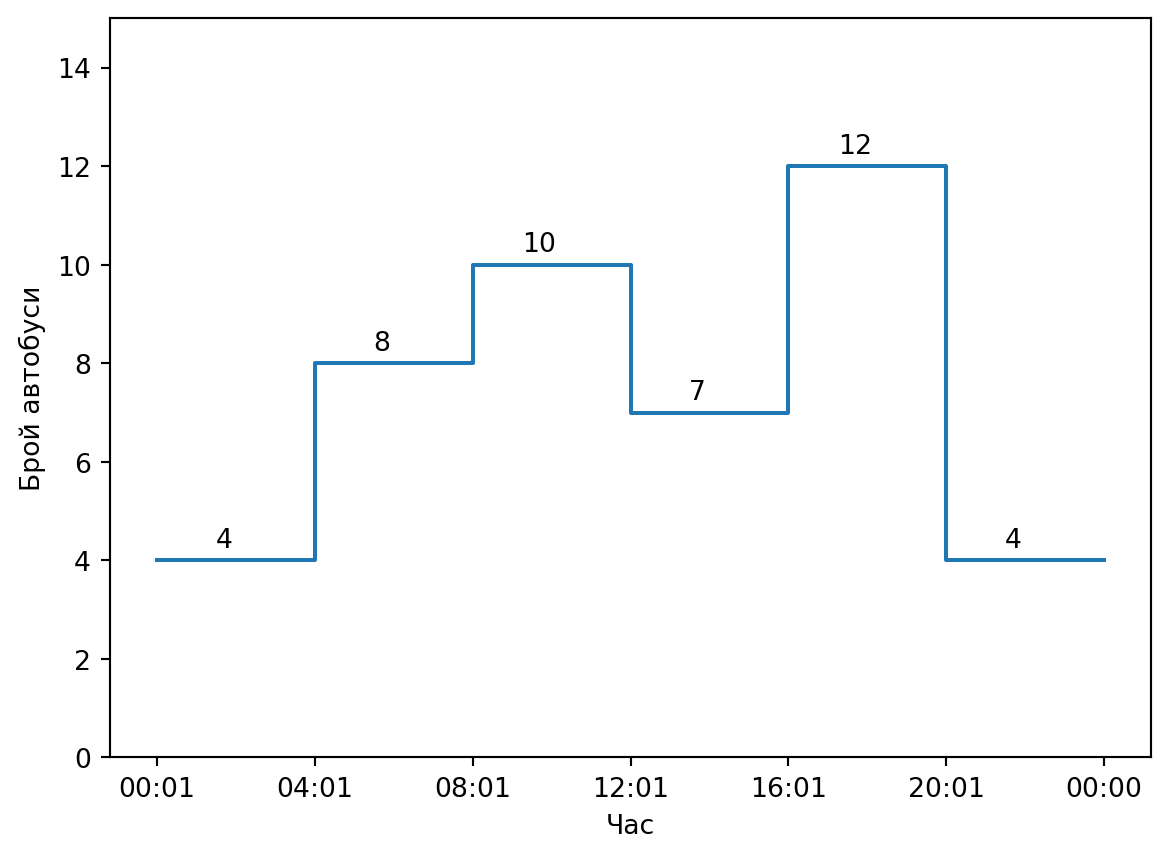

In [24]:
#| fold-code: true
#| label: fig-bus-schedule-graph
#| fig-cap: "График на натоварване на автобусите през деня"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create DataFrame
schedule_df = pd.DataFrame({
    'shift': ["00:01", "04:01", "08:01", "12:01", "16:01", "20:01", "00:00"],
    'demand': [4, 8, 10, 7, 12, 4, 4]
})

# Plot
plt.step(schedule_df['shift'], schedule_df['demand'], where='post')
plt.ylim(0, 15)
plt.xlabel('Час')
plt.ylabel('Брой автобуси')
for i, txt in enumerate(schedule_df['demand']):
    if i == len(schedule_df) - 1:
        continue

    plt.annotate(txt, (schedule_df['shift'][i], schedule_df['demand'][i]), textcoords="offset points", xytext=(25, 5),
                 ha='center')
plt.show()

<!-- :::{.callout-note collapse="true"}
## Математически модел

Променливи:

$$
x_{00}: \text{брой автобуси, които започват смяна в 00:01} \\
x_{04}: \text{брой автобуси, които започват смяна в 04:01} \\
x_{08}: \text{брой автобуси, които започват смяна в 08:01} \\
x_{12}: \text{брой автобуси, които започват смяна в 12:01} \\
x_{16}: \text{брой автобуси, които започват смяна в 16:01} \\
x_{20}: \text{брой автобуси, които започват смяна в 20:01}
$$

Целта на задачата е да намери минималния брой автобуси, които са необходими за обслужването на линията, т.е. сборът от всички автобуси, които са необходими за обслужването на линията, трябва да бъде минимален:

$$
\min x_{00} + x_{04} + x_{08} + x_{12} + x_{16} + x_{20}
$$

Ограничения:

1. Между 00:01 и 04:00 са необходими поне 4 автобуса. В този интервал ще се
движат автобусите, които започват смяна в 00:01 и 20:01 на предишния ден, тъй като смените продължават 8 часа.

$$
x_{20} + x_{00} \geq 4
$$

2. Между 04:01 и 08:00 са необходими поне 8 автобуса.

$$
x_{00} + x_{04} \geq 8
$$

3. Между 08:01 и 12:00 са необходими поне 10 автобуса.

$$
x_{04} + x_{08} \geq 10
$$

4. Между 12:01 и 16:00 са необходими поне 7 автобуса.

$$
x_{08} + x_{12} \geq 7
$$

5. Между 16:01 и 20:00 са необходими поне 12 автобуса.

$$
x_{12} + x_{16} \geq 12
$$

6. Между 20:01 и 00:00 са необходими поне 4 автобуса.

$$
x_{16} + x_{20} \geq 4
$$

::: -->

In [25]:
# Drop the last row as it is the same as the first one
sdf = schedule_df[:-1]

sdf.set_index('shift', inplace=True)
sdf

m = gp.Model("Bus Schedule")
# m.Params.LogToConsole = 0

# Create variables

shifts = m.addVars(sdf.index, name="Shifts", vtype=GRB.INTEGER)

# Set objective

m.setObjective(shifts.sum(), GRB.MINIMIZE)

# Set constraints

m.addConstrs(
    (
        shifts[idx] + shifts[sdf.index[i - 1]] >= sdf.loc[idx, "demand"] for i, idx in enumerate(sdf.index)
    ),
    name="Demand"
)

m.optimize()

vars_df = pd.DataFrame(columns=['Variable', 'Value'], data=[(v.VarName, v.X) for v in m.getVars()])


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.2 LTS")


CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]


Thread count: 32 physical cores, 32 logical processors, using up to 32 threads


Optimize a model with 6 rows, 6 columns and 12 nonzeros


Model fingerprint: 0x65e7efa4


Variable types: 0 continuous, 6 integer (0 binary)


Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


  Objective range  [1e+00, 1e+00]


  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+00, 1e+01]


Found heuristic solution: objective 26.0000000


Presolve time: 0.00s


Presolved: 6 rows, 6 columns, 12 nonzeros


Variable types: 0 continuous, 6 integer (0 binary)


Root relaxation: cutoff, 3 iterations, 0.00 seconds (0.00 work units)


    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


     0     0     cutoff    0        26.00000   26.00000  0.00%     -    0s


Explored 1 nodes (3 simplex iterations) in 0.00 seconds (0.00 work units)


Thread count was 32 (of 32 available processors)


Solution count 1: 26 


Optimal solution found (tolerance 1.00e-04)


Best objective 2.600000000000e+01, best bound 2.600000000000e+01, gap 0.0000%


In [26]:
#| label: tbl-bus-schedule-variables
#| tbl-cap: "Стойности на променливите в оптимума за автобусния график"

vars_df


,Variable,Value
0,Shifts[00:01],0.00
1,Shifts[04:01],8.00
2,Shifts[08:01],2.00
3,Shifts[12:01],5.00
4,Shifts[16:01],7.00
5,Shifts[20:01],4.00


In [27]:
#| label: tbl-bus-schedule-constraints
#| tbl-cap: "Ограничения за автобусния график в оптимума за автобусния график"

# constr_df

## Радиотерапия

При радиотерапия се използва радиация за лечение на рак. Целта на радиотерапията е да унищожи раковите клетки, като се опитва да се намали въздействието върху здравите тъкани. В този пример разглеждаме задача, в която имаме 6 лъча радиация, които се прилагат върху 9 групи тъкани. Всяка група тъкани може да облъчена от два лъча радиация (ляво и горе). Тъканите се различават по това, какво количество радиация ще получат при единица интензивност на всеки лъч. Тази информация е представена в  @tbl-radiation-therapy (и в друг формат в @tbl-radiation-therapy-pd), например при прилагане на една едицина интензивност при лъч 1, тъкан 1,1 ще получи 1 единица радиация, докато тъкан 1,2 ще получи 2 единици радиация.

|       |                      Лъч 4 |                      Лъч 5 |                      Лъч 6 |
|-------|---------------------------:|---------------------------:|---------------------------:|
| Лъч 1 |       [1/1]{color="green"} |   [2/1]{color="firebrick"} |       [2/1]{color="green"} |
| Лъч 2 |   [1/2]{color="firebrick"} |        [2/2]{color="blue"} | [2.5/2]{color="firebrick"} |
| Лъч 3 | [1.5/1]{color="firebrick"} | [1.5/1]{color="firebrick"} |     [2.5/1]{color="green"} |
: Тъкани и погълната радиация при единица интензивност на лъчите {#tbl-radiation-therapy}

Целта е здравите тъкани (в клетки 1,1; 1,2; 2,2; 3,3) да получат възможно най-малка доза радиация, докато в същото време болните тъкани трябва да
получат поне 7Gy (Грей), за да бъдат унищожени. Тъканта на гръбначния мозък (в клетка 2,2) е особено чувствителна и не трябва да
бъде изложена на радиация повече от 5Gy.

:::{.callout-note collapse="true"}
## Математически модел

$$
\begin{align*}
& \min (x_1 + x_4) + (2x_2 + 2x_5) + (2x_1 + x_6) + (2.5x_3 + x_6) = \\ 3x_1 + 2x_2 + 2.5x_3 + 2x_6 \\
& x_2 + 2x_4 \geq 7\\
& 1.5x_3 + x_4 \geq 7 \\
& 2x_1 + x_5 \geq 7 \\
& 1.5x_3 + x_5 \geq 7 \\
& 2.5x_2 + 2x_6 \geq 7 \\
& 2x_2 + 2x_5 \leq 5
\end{align*}
$$
:::


In [28]:
# #| label: tbl-radiation-therapy-pd
# #| tbl-cap: "Тъкани и погълната радиация при единица интензивност на лъчите (формат 2)"

# import pandas as pd

# dt = pd.DataFrame({
#     "Страна 1": [1, 2, 2, 1, 2, 2.5, 1.5, 1.5, 2.5],
#     "Страна 2": [1, 1, 1, 2, 2, 2, 1, 1, 1],
#     "isCancer": [False, True, False, True, False, True, True, True, False],
#     "isSpinal": [False, False, False, False, True, False, False, False, False]
# }, index=pd.MultiIndex.from_product([range(1, 4), range(4, 7)]))
# dt


In [29]:
# # Implementation 1

# m = gp.Model("Radiation Therapy")

# x = m.addVars([1, 2, 3, 4, 5, 6], name="x")

# m.setObjective(
#     x[1] + x[4] + 2 * x[2] + 2 * x[5] + 2 * x[1] + x[6] + 2.5 * x[3] + x[6], GRB.MINIMIZE
# )

# m.addConstr(
#     x[2] + 2 * x[4] >= 7, "MinimalDoseCancer1"
# )
# m.addConstr(
#     1.5 * x[3] + x[4] >= 7, "MinimalDoseCancer2"
# )
# m.addConstr(
#     2 * x[1] + x[5] >= 7, "MinimalDoseCancer3"
# )
# m.addConstr(
#     1.5 * x[3] + x[5] >= 7, "MinimalDoseCancer4"
# )
# m.addConstr(
#     2.5 * x[2] + 2 * x[6] >= 7, "MinimalDoseCancer5"
# )
# m.addConstr(
#     2 * x[2] + 2 * x[5] <= 5, "MaximalDoseSpinal"
# )

# m.optimize()

# vars_df = pd.DataFrame(columns=['Variable', 'Value'], data=[(v.VarName, v.X) for v in m.getVars()])
# constr_df = pd.DataFrame(columns=['Constraint', 'Shadow Price', 'Lower', 'Upper'],
#                             data=[(c.ConstrName, c.Pi, c.SARHSLow, c.SARHSUp) for c in m.getConstrs()])
# # m.write("radiation_impl1.lp")
# vars_df


In [30]:
# # Implementation 2

# import gurobipy as gp
# from gurobipy import GRB

# m = gp.Model("Radiation Therapy")

# # Create variables

# idx_left = dt.index.get_level_values(0).drop_duplicates()
# idx_upper = dt.index.get_level_values(1).drop_duplicates()

# beams_left = m.addVars(idx_left, name="beam_left")
# beams_upper = m.addVars(idx_upper, name="beam_upper")

# # Set objective
# # Radiation from the upper beams

# rad_upper = gp.quicksum(
#     dt.loc[(i, j), "Страна 2"] * beams_upper[j] for i, j in dt.index[~dt["isCancer"]])

# rad_lower = gp.quicksum(
#     dt.loc[(i, j), "Страна 1"] * beams_left[i] for i, j in dt.index[~dt["isCancer"]])

# m.setObjective(rad_upper + rad_lower, GRB.MINIMIZE)

# # Constraints

# m.addConstrs(
#     (
#         dt.loc[(i, j), "Страна 1"] * beams_left[i] +
#         dt.loc[(i, j), "Страна 2"] * beams_upper[j] >= 7
#         for i, j in dt.index[dt["isCancer"]]
#     ),
#     name="MinimalDoseCancer"
# )

# # Maximal dose for the spinal cord

# m.addConstrs(
#     (
#         dt.loc[(i, j), "Страна 1"] * beams_left[i] +
#         dt.loc[(i, j), "Страна 2"] * beams_upper[j] <= 5
#         for i, j in dt.index[dt["isSpinal"]]
#     ),
#     name="MaximalDoseSpinal"
# )

# m.optimize()

# vars_df = pd.DataFrame(columns=['Variable', 'Value'], data=[(v.VarName, v.X) for v in m.getVars()])
# constr_df = pd.DataFrame(columns=['Constraint', 'Shadow Price', 'Lower', 'Upper'],
#                          data=[(c.ConstrName, c.Pi, c.SARHSLow, c.SARHSUp) for c in m.getConstrs()])
# # m.write("radiation_impl2.lp")
# vars_df
